# SLA-Analysis
### Royer Ticse Torres, July 2019


This notebook is a SLA-analysis in python step-by-step. Starting from raw data to making a prediction model on the "ticket_cientista" dataset.

![title](sla1.png "Header")



# Dive into data
First things first!. Understand the content of the data

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from datetime import datetime
from dateutil.parser import parse
import seaborn as sb
import scipy
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.externals import joblib

import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 10, 5
sb.set_style('whitegrid')

In [2]:
# Load the data set
address = 'dataset/ticket_cientista.csv'
df = pd.read_csv(address , sep=';')
df['datetime'] = pd.to_datetime(df['currentDateTime'], format='ISODate("%Y-%m-%dT%H:%M:%S.000%z")')
#timezone converted to UTC
df['datetime'] = pd.to_datetime(df['datetime'], utc='True')
df = df.set_index('datetime')
#remove the timezone from the index
df.index = df.index.tz_convert(None)
df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (25,35,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,attendanceType,attendanceTypeId,averageRepairTime,averageRepairTimeType,averageServiceTime,averageSolutionTime,averageWaitingTimeType,callBranch,callBranchName,callCloseDate,...,repairTimeEngineer,schedulingDate,schedulingDateTime,schedulingTime,segmentId,siteCity,siteName,siteState,slaStatus,type
datetime,,,,,,,,,,,,,,,,,,,,,
2018-02-07 18:49:02,1,5,0,35.0,222,222,52.0,86,Natal,NaN,...,0.0,20180207,"ISODate(""2018-02-07T15:00:00.000-02:00"")",15:00,35,CAICÓ,LEXBRA000010380,RN,NaN,U
2019-02-22 16:03:17,0,2,164,27.0,131,295,66.0,52,Campinas,20190222.0,...,164.0,NaN,NaN,NaN,35,PIRACICABA,LEXMARK00013169,SP,N,U
2019-02-22 15:11:45,0,2,19,27.0,264,283,66.0,52,Campinas,20190222.0,...,19.0,NaN,NaN,NaN,35,JUNDIAI,LEXMARK00013402,SP,N,U
2019-02-26 15:53:54,0,2,360,56.0,257,617,67.0,70,Paissandu,NaN,...,0.0,NaN,NaN,NaN,35,SAO PAULO,LEXMARK00004162,SP,S,U
2019-02-26 15:31:44,0,2,63,21.0,146,209,55.0,AD,Campo Grande,NaN,...,0.0,NaN,NaN,NaN,35,CAMPO GRANDE,LEXMARK00012469,MS,N,U


In [3]:
#df.info()

In [4]:
#Let's look the deadline for each call 
df_times = df[['openDateTime', 'deadlineDateTime']]
df_times = df_times.dropna()
df_times = df_times.loc[(df_times.index >'2019-01-01')]
df_times = df_times.sort_index()
df_times.head()
df_times.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41668 entries, 2019-01-01 13:43:43 to 2019-02-26 17:48:26
Data columns (total 2 columns):
openDateTime        41668 non-null object
deadlineDateTime    41668 non-null object
dtypes: object(2)
memory usage: 976.6+ KB


In [5]:
df_deadline = df_times.sample(n=3200,random_state=97, axis=0)

df_deadline["openDateTime_utc"] = pd.to_datetime(df_deadline['openDateTime'], format='ISODate("%Y-%m-%dT%H:%M:%S.000%z")',errors='ignore')
df_deadline["openDateTime_utc"] = pd.to_datetime(df_deadline['openDateTime_utc'], utc='True')
df_deadline["deadlineDateTime_utc"] = pd.to_datetime(df_deadline['deadlineDateTime'], format='ISODate("%Y-%m-%dT%H:%M:%S.000%z")')
df_deadline["deadlineDateTime_utc"] = pd.to_datetime(df_deadline['deadlineDateTime_utc'], utc='True')

df_deadline["deadline"] = df_deadline["deadlineDateTime_utc"] - df_deadline["openDateTime_utc"] 
df_deadline["deadline"].mean()

Timedelta('4 days 02:49:14.568750')

In [6]:
df_deadline["deadline"].median()

Timedelta('2 days 13:58:30')

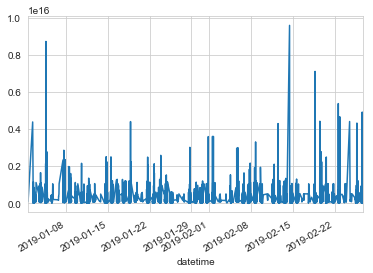

In [7]:
df_deadline["deadline"].plot()

# What data tell us?

* Mean deadline for a call is ~4 days and Median ~2 days.


Since it is essential to prevent SLA violations as much as possible to enhance customer satisfaction and avoid penalties. The proposed model will run in a 2-day period so that the manager can make decisions based on the predictions for the next two days. 


In order to calculate the SLA we need the total number of calls and the calls closed on time. Therefore, the model will make a prediction on the calls for the next two days as well as the number of calls closed on time.



In [8]:
def dateList(start_date, end_date):
    dateList =[]
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        dateList.append(single_date.strftime("%Y-%m-%d"))
    return dateList

In [9]:
def data_calls2(df, str_days):

    pdList = []
    for i in range(0,len(str_days),2):
        df_day = pd.DataFrame()
        df_day = df.loc[str_days[i]:str_days[i+1]]
        df_day = df_day['customerCode'].value_counts()
        df_day.name = "Day_"+str(i+1)
        pdList.append(df_day) 
    df_combined = pd.concat(pdList, axis =1)
    df_combined = df_combined.fillna(0)
    return df_combined

In [10]:
def data_calls2_onTime(df, str_days):

    pdList = []
    for i in range(0,len(str_days),2):
        df_day = pd.DataFrame()
        df_day = df.loc[str_days[i]:str_days[i+1]]
        df_day = df_day[(df_day["onTimeSolution"] =='S')]
        df_day = df_day['customerCode'].value_counts()
        df_day.name = "Day_"+str(i+1)
        pdList.append(df_day) 
    df_combined = pd.concat(pdList, axis =1)
    df_combined = df_combined.fillna(0)
    return df_combined

In [11]:
def melting_data(df):
    df = df.reset_index()
    df = df.melt(id_vars='index', var_name='Days', value_name='Calls')
    df['Days'] = df['Days'].str.extract('(\d+)', expand=False).astype(int)
    df = df.sort_values(['Days', 'index'])
    return df

In [12]:
def adding_features(df):
    #melt4 = melt.copy()
    df['Last_Day_Calls'] = df.groupby(['index'])['Calls'].shift()
    df['Last_Day_Diff'] = df.groupby(['index'])['Last_Day_Calls'].diff()
    df['before_Last_Day_Calls'] = df.groupby(['index'])['Calls'].shift(2)
    df['before_Last_Day_Diff'] = df.groupby(['index'])['before_Last_Day_Calls'].diff()
    df['before-2_Last_Day_Calls'] = df.groupby(['index'])['Calls'].shift(3)
    df['before-2_Last_Day_Diff'] = df.groupby(['index'])['before-2_Last_Day_Calls'].diff()
    #df['before-4_Last_Day_Calls'] = df.groupby(['index'])['Calls'].shift(4)
    #df['before-4_Last_Day_Diff'] = df.groupby(['index'])['before-4_Last_Day_Calls'].diff()
    df= df.dropna()
    return df

In [13]:
start_date = '2019-01-01'
end_date   = '2019-01-30'

JanDays = dateList(start_date, end_date)

In [14]:
start_date = '2019-02-01'
end_date   = '2019-02-26'
FebDays = dateList(start_date, end_date)

In [15]:
#Total number of calls per client counting on alternating days (checkpoints)
# Day_1 correspond to the calls on 01.01 and 02.01
# Day_3 correspond to the calls on 03.01 and 04.01
# and so on.
calls_Jan = data_calls2(df, JanDays )
calls_Jan

,Day_1,Day_3,Day_5,Day_7,Day_9,Day_11,Day_13,Day_15,Day_17,Day_19,Day_21,Day_23,Day_25,Day_27,Day_29
215,179.0,321.0,24.0,356.0,383.0,198,273,425,477,42.0,384,388,226,219.0,399
2581,21.0,70.0,0.0,49.0,38.0,30,13,30,77,0.0,57,39,17,14.0,40
3363,131.0,257.0,13.0,251.0,248.0,164,185,261,267,19.0,333,260,112,166.0,309
8068,74.0,209.0,9.0,159.0,187.0,89,105,198,236,7.0,197,171,113,103.0,221
39159,0.0,3.0,2.0,17.0,28.0,10,25,54,47,3.0,40,68,23,34.0,41
87520,86.0,255.0,122.0,249.0,264.0,250,104,229,200,103.0,202,295,209,144.0,232
372301,248.0,574.0,212.0,503.0,563.0,472,317,588,680,227.0,587,650,417,354.0,636
797391,0.0,0.0,0.0,0.0,0.0,1,3,3,4,0.0,2,1,1,0.0,2
900995,1.0,9.0,0.0,10.0,5.0,5,2,24,9,1.0,7,9,8,2.0,11


Text(0, 0.5, 'Calls')

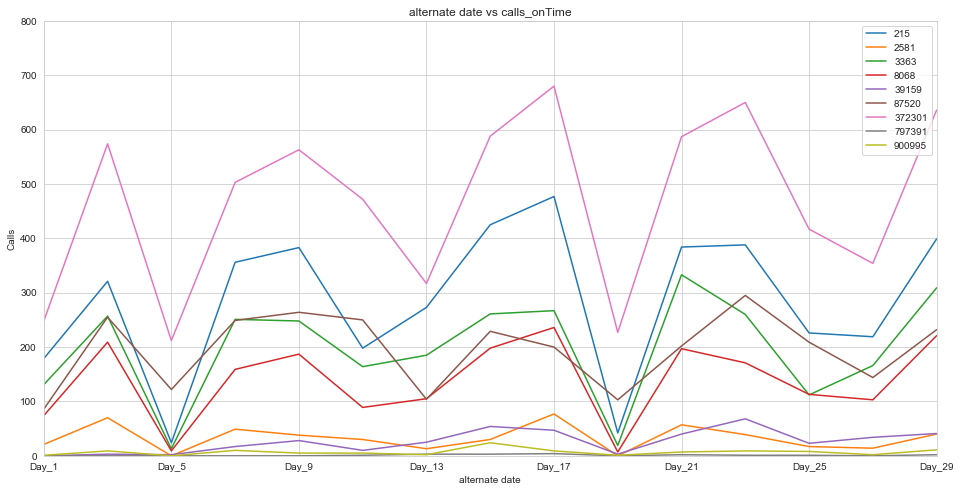

In [16]:
#Visually, this looks like:
calls_Jan_T = calls_Jan.T
calls_Jan_T.plot(title='alternate date vs calls_onTime', figsize=(16,8),
                 ylim=(0,800))
plt.xlabel('alternate date')
plt.ylabel('Calls')

In [17]:
#Total number of calls closed on time per client counting on alternating days
# Day_1 correspond to the calls closed on time on 01.01 and 02.01
# Day_3 correspond to the calls closed on time on 03.01 and 04.01
# and so on.
calls_onTime_Jan = data_calls2_onTime(df, JanDays )
calls_onTime_Jan

,Day_1,Day_3,Day_5,Day_7,Day_9,Day_11,Day_13,Day_15,Day_17,Day_19,Day_21,Day_23,Day_25,Day_27,Day_29
215,136.0,271.0,19.0,305.0,296.0,141,180,345,364,32.0,297,303.0,185,178.0,313
2581,20.0,65.0,0.0,49.0,36.0,28,12,24,74,0.0,48,35.0,16,14.0,37
3363,125.0,247.0,13.0,243.0,234.0,160,178,250,257,19.0,312,245.0,110,160.0,297
8068,28.0,95.0,9.0,77.0,77.0,24,47,82,127,5.0,81,59.0,60,48.0,101
39159,0.0,3.0,2.0,16.0,26.0,10,21,41,39,2.0,31,56.0,18,30.0,33
87520,61.0,182.0,104.0,183.0,188.0,187,84,164,133,92.0,139,197.0,150,119.0,169
372301,161.0,375.0,142.0,355.0,381.0,289,223,379,483,148.0,371,420.0,264,236.0,392
797391,0.0,0.0,0.0,0.0,0.0,1,3,3,4,0.0,2,0.0,1,0.0,2
900995,1.0,7.0,0.0,10.0,5.0,3,2,21,9,1.0,5,6.0,3,1.0,9


Text(0, 0.5, 'Calls')

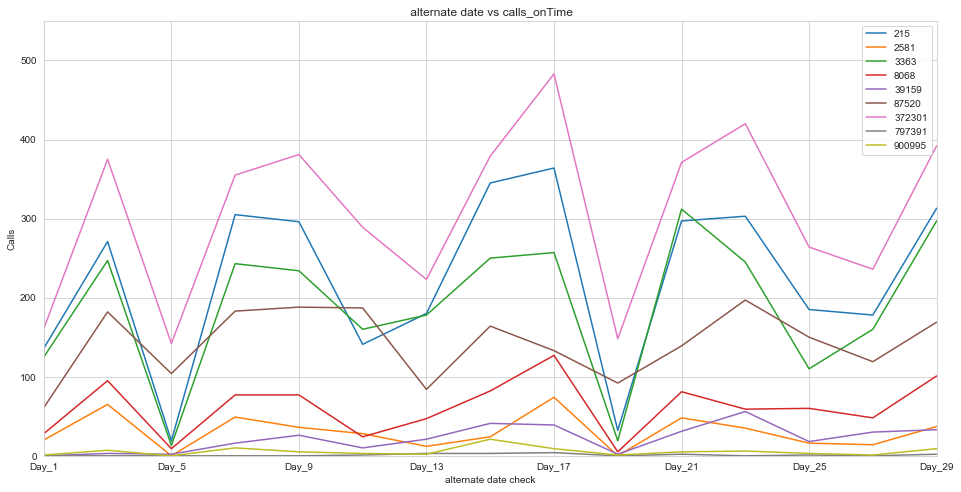

In [18]:
#Visually, this looks like:
calls_onTime_Jan_T = calls_onTime_Jan.T

calls_onTime_Jan_T.plot(title=' alternate date vs calls_onTime', figsize=(16,8),
                 ylim=(0,550))
plt.xlabel('alternate date check')
plt.ylabel('Calls')

In [19]:
data_calls_Jan= melting_data(calls_Jan) 
#data_calls_Jan.head()

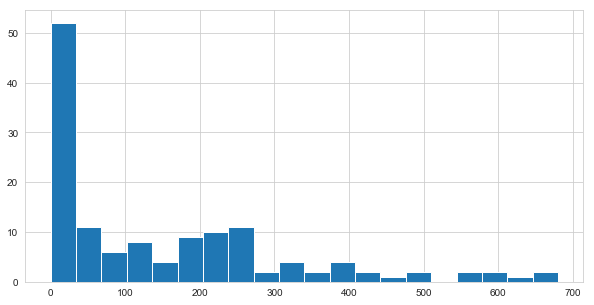

In [20]:
# Let's look at the distribution of calls in the January dataset
data_calls_Jan['Calls'].hist(bins=20, figsize=(10,5))

In [21]:
data_calls_onTime_Jan= melting_data(calls_onTime_Jan) 
#data_calls_onTime_Jan.head()

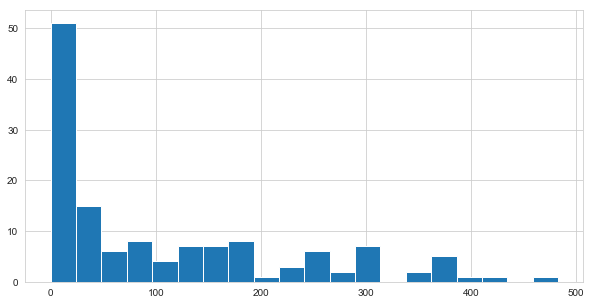

In [22]:
# Let's look at the distribution of calls closed on time in the January dataset
data_calls_onTime_Jan['Calls'].hist(bins=20, figsize=(10,5))

### Feature Engineering

We need to have variables to send to the machine learning technique and get the predictions. 
I will add features based on historical process instances.

* Last Day Calls: the amount of calls that a client had in the previous day check (t-1)
* Last Day Diff: the difference between the amount of calls in the previous day check and the day check before it (t-1 - t-2)
* before Last Day Calls: the amount of calls that a client had in t-2
* before Last Day Diff: the difference between the amount of calls in t-2 - t-3
* before 2 Last Day Calls: the amount of calls that a client had in t-3
* before 2 Last Day Diff: the difference between the amount of calls in t-3 - t-4


In [23]:
data_calls_Jan = adding_features(data_calls_Jan)
data_calls_Jan.head()

,index,Days,Calls,Last_Day_Calls,Last_Day_Diff,before_Last_Day_Calls,before_Last_Day_Diff,before-2_Last_Day_Calls,before-2_Last_Day_Diff
36,215,9,383.0,356.0,332.0,24.0,-297.0,321.0,142.0
37,2581,9,38.0,49.0,49.0,0.0,-70.0,70.0,49.0
38,3363,9,248.0,251.0,238.0,13.0,-244.0,257.0,126.0
39,8068,9,187.0,159.0,150.0,9.0,-200.0,209.0,135.0
40,39159,9,28.0,17.0,15.0,2.0,-1.0,3.0,3.0


In [24]:
data_calls_onTime_Jan = adding_features(data_calls_onTime_Jan)
data_calls_onTime_Jan.head()

,index,Days,Calls,Last_Day_Calls,Last_Day_Diff,before_Last_Day_Calls,before_Last_Day_Diff,before-2_Last_Day_Calls,before-2_Last_Day_Diff
36,215,9,296.0,305.0,286.0,19.0,-252.0,271.0,135.0
37,2581,9,36.0,49.0,49.0,0.0,-65.0,65.0,45.0
38,3363,9,234.0,243.0,230.0,13.0,-234.0,247.0,122.0
39,8068,9,77.0,77.0,68.0,9.0,-86.0,95.0,67.0
40,39159,9,26.0,16.0,14.0,2.0,-1.0,3.0,3.0


In [25]:
# the same procedure for the Feb data set.
calls_Feb = data_calls2(df, FebDays )

data_calls_Feb = melting_data(calls_Feb)

data_calls_Feb = adding_features(data_calls_Feb)

data_calls_Feb.head()

,index,Days,Calls,Last_Day_Calls,Last_Day_Diff,before_Last_Day_Calls,before_Last_Day_Diff,before-2_Last_Day_Calls,before-2_Last_Day_Diff
36,215,9,27.0,395.0,48.0,347.0,158.0,189.0,-57.0
37,2581,9,5.0,41.0,10.0,31.0,19.0,12.0,-49.0
38,3363,9,10.0,313.0,11.0,302.0,138.0,164.0,23.0
39,8068,9,6.0,162.0,-28.0,190.0,91.0,99.0,-14.0
40,39159,9,1.0,61.0,12.0,49.0,17.0,32.0,-1.0


In [26]:
calls_onTime_Feb = data_calls2_onTime(df, FebDays )

data_calls_onTime_Feb = melting_data(calls_onTime_Feb)

data_calls_onTime_Feb = adding_features(data_calls_onTime_Feb)

data_calls_onTime_Feb.head()

,index,Days,Calls,Last_Day_Calls,Last_Day_Diff,before_Last_Day_Calls,before_Last_Day_Diff,before-2_Last_Day_Calls,before-2_Last_Day_Diff
36,215,9,24.0,287.0,17.0,270.0,135.0,135.0,-56.0
37,2581,9,5.0,37.0,7.0,30.0,19.0,11.0,-49.0
38,3363,9,10.0,307.0,21.0,286.0,132.0,154.0,17.0
39,8068,9,4.0,69.0,-14.0,83.0,36.0,47.0,-2.0
40,39159,9,0.0,47.0,15.0,32.0,19.0,13.0,0.0


# Making a predictive model

The prediction model is based on machine learning regression techniques and trained using historical process instances.

The idea of this model is to train in a single dataset. The client Id and the checkpoint day become a variable in our model. The model would be able to learn more subtle patterns that repeat across clients and perform better.

In [27]:
#Let's use the Root Mean Squared Error as evaluation metric. 
from sklearn.metrics import mean_squared_error
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [28]:
# use data January as train set & data Feb as test set.
train = data_calls_Jan
# Create the X and y arrays
# Remove calls from the training data
X_train =  train.drop(['Calls'], axis=1)
y_train =  train['Calls'].values

In [29]:
# Fit regression model
model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [30]:
# Save the trained model to a file so we can use it later
#joblib.dump(model, 'trained_calls_regresion_model.pkl')

In [31]:
# Load the trained model created
calls_model = joblib.load('trained_calls_regresion_model.pkl')

importance = calls_model.feature_importances_

# These are the feature labels from our data set
feature_labels = np.array(['index','Days', 'Last_Day_Calls','Last_Day_Diff','before_Last_Day_Calls', 
                           'before_Last_Day_Diff', 'before-2_Last_Day_Calls', 'before-2_Last_Day_Diff',])
                          #'before-4_Last_Day_Calls', 'before-4_Last_Day_Diff'])
    
feauture_indexes_by_importance = importance.argsort()

# Print each feature label, from least important to most important
for index in feauture_indexes_by_importance:
    print("{} - {:.2f}%".format(feature_labels[index], (importance[index] * 100.0)))
    

Days - 0.59%
index - 3.25%
Last_Day_Diff - 3.29%
before_Last_Day_Diff - 3.39%
before_Last_Day_Calls - 4.29%
Last_Day_Calls - 4.50%
before-2_Last_Day_Diff - 9.46%
before-2_Last_Day_Calls - 71.23%


In [32]:
# Find the error rate on the test set (Feb data)
# Since we are only predicting the calls for the next two days, we use Feb checkpoints for test the model.
mean_error = []
for day in range(9,21,2):
    val = data_calls_Feb[data_calls_Feb['Days'] == day]
    xts = val.drop(['Calls'], axis=1)
    yts = val['Calls'].values
    p = calls_model.predict(xts)
    error = rmse(yts, p)
    print('checkpoint day %d - Error %.5f' % (day, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

checkpoint day 9 - Error 85.98164
checkpoint day 11 - Error 49.66460
checkpoint day 13 - Error 38.85638
checkpoint day 15 - Error 44.58522
checkpoint day 17 - Error 55.26688
checkpoint day 19 - Error 78.32627
Mean Error = 58.78016


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


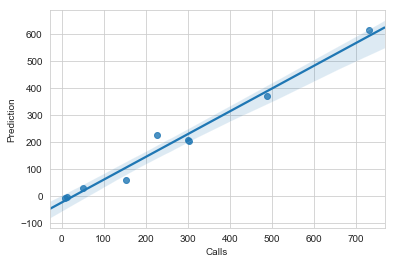

In [33]:
#Let's take a look at our predictions of calls for day 19.
val.loc[:, 'Prediction'] = np.round(p)
sb.regplot(val["Calls"], val["Prediction"], scatter=True)

In [34]:
#Let's create a similar model for the prediction of calls closed on time.
#train in January
train2= data_calls_onTime_Jan
X_train2 =  train2.drop(['Calls'], axis=1)
y_train2 =  train2['Calls'].values

In [35]:
model_calls_onTime = GradientBoostingRegressor(n_estimators=400, learning_rate=0.01)
model_calls_onTime.fit(X_train2, y_train2)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [36]:
#joblib.dump(model, 'trained_calls_onTime_regresion_model.pkl')

In [37]:
calls_onTime_model = joblib.load('trained_calls_onTime_regresion_model.pkl')

importance = calls_onTime_model.feature_importances_

feature_labels = np.array(['index','Days', 'Last_Day_Calls','Last_Day_Diff','before_Last_Day_Calls', 
                           'before_Last_Day_Diff', 'before-2_Last_Day_Calls', 'before-2_Last_Day_Diff'])
                          #'before-4_Last_Day_Calls', 'before-4_Last_Day_Diff'])
feauture_indexes_by_importance = importance.argsort()

# Print each feature label, from least important to most important
for index in feauture_indexes_by_importance:
    print("{} - {:.2f}%".format(feature_labels[index], (importance[index] * 100.0)))

Days - 0.59%
index - 3.25%
Last_Day_Diff - 3.29%
before_Last_Day_Diff - 3.39%
before_Last_Day_Calls - 4.29%
Last_Day_Calls - 4.50%
before-2_Last_Day_Diff - 9.46%
before-2_Last_Day_Calls - 71.23%


In [38]:
# Find the error rate on the test set (Feb data)
# Since we are only predicting the calls closed on time for the next two days, we use Feb checkpoints for test the model.
mean_error = []
for day in range(9,21,2):
    val = data_calls_onTime_Feb[data_calls_onTime_Feb['Days'] == day]
    xts = val.drop(['Calls'], axis=1)
    yts = val['Calls'].values
    p = calls_onTime_model.predict(xts)
    error = rmse(yts, p)
    print('checkpoint day %d - Error %.5f' % (day, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

checkpoint day 9 - Error 91.41371
checkpoint day 11 - Error 34.15436
checkpoint day 13 - Error 39.15749
checkpoint day 15 - Error 57.86050
checkpoint day 17 - Error 76.05881
checkpoint day 19 - Error 77.71812
Mean Error = 62.72716


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


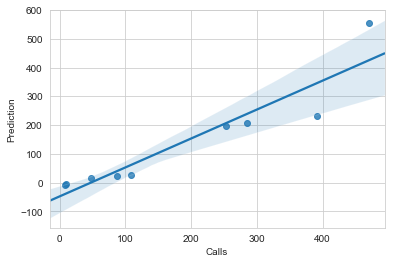

In [39]:
#Let's take a look at our predictions for calls closed on time for day 19.
val.loc[:, 'Prediction'] = np.round(p)
sb.regplot(val["Calls"], val["Prediction"], scatter=True)


Definitely we should investigate more to improve this solution.

# Make predictions and submission

In [40]:
# Load the model we trained previously
calls_model = joblib.load('trained_calls_regresion_model.pkl')

In [41]:
# define the checkpoint day for the prediction of calls
day27 = pd.DataFrame(columns=['index','Days', 'Last_Day_Calls','Last_Day_Diff','before_Last_Day_Calls', 
                           'before_Last_Day_Diff', 'before-2_Last_Day_Calls', 'before-2_Last_Day_Diff'])
day27.loc[0]= [215, 27, 762, 734, 28, -431, 459, -29]
day27.loc[1]= [2581, 27, 86, 86, 0, -40, 40, -11]
day27.loc[2]= [3363, 27, 431, 405, 26, -258, 284, -18]
day27.loc[3]= [8068, 27, 484, 468, 16, -195, 211, -15]
day27.loc[4]= [39159, 27, 401, 385, 16 ,-271, 287, 134]
day27.loc[5]= [87520, 27, 327, 243, 84, -182, 266, -34]
day27.loc[6]= [372301, 27, 1077, 753, 324, -445, 769, 37]
day27.loc[7]= [797391, 27, 1, 1, 0, -6, 6, -2]
day27.loc[8]= [900995, 27, 25, 25, 0, -13, 13, 1]
#day27

In [42]:
# Run the model and make a prediction of calls for day 27 (calls on 27.02 and 28.02.)
pred1 = calls_model.predict(day27)
np.round(pred1)

array([472., 125., 249., 247., 231., 297., 663.,   5.,  13.])

In [43]:
# define the checkpoint day for the prediction of calls closed on time
day27_onTime = pd.DataFrame(columns=['index','Days', 'Last_Day_Calls','Last_Day_Diff','before_Last_Day_Calls', 
                           'before_Last_Day_Diff', 'before-2_Last_Day_Calls', 'before-2_Last_Day_Diff'])
day27_onTime.loc[0]= [215, 27, 630, 614, 16, -356, 372, -19]
day27_onTime.loc[1]= [2581, 27, 83, 83, 0, -35, 35, -13]
day27_onTime.loc[2]= [3363, 27, 406, 381, 25, -240, 265, -20]
day27_onTime.loc[3]= [8068, 27, 345, 331, 14, -74, 88, -21]
day27_onTime.loc[4]= [39159, 27, 329, 316, 13 ,-223, 236, 149]
day27_onTime.loc[5]= [87520, 27, 270, 196, 74, -143, 217, -36]
day27_onTime.loc[6]= [372301, 27, 717, 496, 221, -253, 474, 3]
day27_onTime.loc[7]= [797391, 27, 1, 1, 0, -5, 5, -3]
day27_onTime.loc[8]= [900995, 27, 18, 18, 0, -11, 11, 1]
#day27_onTime

In [44]:
# Load the model we trained previously
calls_model_onTime = joblib.load('trained_calls_onTime_regresion_model.pkl')

In [45]:
# Run the model and make a prediction of calls on time for day 27 (calls closed on time on 27.02 and 28.02.)
pred2 = calls_model_onTime.predict(day27_onTime)
np.round(pred2)

array([340.,  89., 266., 181., 252., 295., 600.,   5.,  11.])

### SLA January

In [46]:
#Just for curiosity let's see the SLA for January per each client.
calls_onTime_Jan_T.sum()/calls_Jan_T.sum()*100

215       78.365161
2581      92.525253
3363      95.766129
8068      44.273340
39159     83.037975
87520     73.097826
372301    65.722823
797391    94.117647
900995    80.582524
dtype: float64

### SLA February

In [47]:
#With the prediction of calls and calls close on time let's calculate the SLA for February 28
calls_onTime_Feb_T = calls_onTime_Feb.T
calls_Feb_T = calls_Feb.T 
N = calls_onTime_Feb_T.sum() + np.round(pred2)
D = calls_Feb_T.sum()+ np.round(pred1)
#SLA Feb
N/D*100

215       77.092229
2581      88.944724
3363      96.107211
8068      52.013423
39159     77.729529
87520     82.882273
372301    65.789156
797391    93.103448
900995    71.929825
dtype: float64

I presented an approach to predict the SLA values for each client. The model defines a concrete point in the execution (2-days period) at which prediction has to be carried out. This defines the input of the prediction, and estimates, which represent predictions about calls (and calls closed on time) which is not yet available in the checkpoint. The model use regression techniques trained with recorded historical data to implement predictions in checkpoints.